In [1]:
import numpy as np
import torch as ch
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from robustness.tools.vis_tools import show_image_column, show_image_row
from robustness.tools.label_maps import CLASS_DICT

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
RES_FILE = '/data/theory/robustopt/shibani/synthfar/Results/objectnet/v0/color_good/output.csv'

In [3]:
df_orig = pd.read_csv(RES_FILE)

In [4]:
df_orig

,Unnamed: 0,uids,preds,labs,hue,saturation,value
0,0,00aee941-b563-4ffb-beee-93e760723291,761,[761],0.0,0.0,0.0
1,1,455d8124-83c1-4bb2-a1aa-6bbc937cbf37,700,[721],0.0,0.0,0.0
2,2,8d455ac3-d2ca-411f-bf18-df8cd4401585,619,[907],0.0,0.0,0.0
3,3,34693102-08c6-4e0d-8ddc-ab0ed2fc229c,606,[882],0.0,0.0,0.0
4,4,f31b198c-0df8-4895-b86d-01627418f54a,419,[902],0.0,0.0,0.0
...,...,...,...,...,...,...,...
8992231,751,86772be7-1c3c-4ef2-ac7e-7cad82f35b26,549,[539],1.0,1.0,1.0
8992232,752,b94e5efd-fbe5-4150-affd-7058d74c4edd,444,"[671, 444]",1.0,1.0,1.0
8992233,753,670548cc-0304-412c-af36-0d1508fbda3c,752,[752],1.0,1.0,1.0
8992234,754,7e7ed456-ea3c-4a64-9446-6241e45a340a,623,[539],1.0,1.0,1.0


In [5]:
all_keys = ['hue', 'saturation', 'value']

In [6]:
grp_keys = ['labs', 'preds', 'hue', 'saturation', 'value']
df = df_orig.groupby(grp_keys).agg(num=('uids', 'count')).reset_index()

In [7]:
df

,labs,preds,hue,saturation,value,num
0,"[409, 530]",409,0.0,0.0,0.0,8
1,"[409, 530]",409,0.0,0.0,0.1,9
2,"[409, 530]",409,0.0,0.0,0.2,9
3,"[409, 530]",409,0.0,0.0,0.3,10
4,"[409, 530]",409,0.0,0.0,0.4,10
...,...,...,...,...,...,...
1853927,[999],999,1.0,1.0,0.6,9
1853928,[999],999,1.0,1.0,0.7,9
1853929,[999],999,1.0,1.0,0.8,9
1853930,[999],999,1.0,1.0,0.9,10


In [8]:
df['labs_int'] = df.labs.apply(lambda x: [int(xx) for xx in x[1:-1].split(',')])

In [9]:
df['sameclass'] = df.apply(lambda r: r['preds'] in r['labs_int'], axis=1)

In [10]:
df

,labs,preds,hue,saturation,value,num,labs_int,sameclass
0,"[409, 530]",409,0.0,0.0,0.0,8,"[409, 530]",True
1,"[409, 530]",409,0.0,0.0,0.1,9,"[409, 530]",True
2,"[409, 530]",409,0.0,0.0,0.2,9,"[409, 530]",True
3,"[409, 530]",409,0.0,0.0,0.3,10,"[409, 530]",True
4,"[409, 530]",409,0.0,0.0,0.4,10,"[409, 530]",True
...,...,...,...,...,...,...,...,...
1853927,[999],999,1.0,1.0,0.6,9,[999],True
1853928,[999],999,1.0,1.0,0.7,9,[999],True
1853929,[999],999,1.0,1.0,0.8,9,[999],True
1853930,[999],999,1.0,1.0,0.9,10,[999],True


## Over all backgrounds

In [11]:
acc = 100 * np.sum(df['num'][df['sameclass']]) / np.sum(df['num'])
print(f"Mean accuracy over all background configs: {acc: .2f}")

Mean accuracy over all background configs:  35.05


In [12]:
conf_df = df.groupby(['labs', 'preds']).agg({'num': 'sum'}).reset_index()

In [13]:
from objectnet_utils import OBJN_TO_IN_MAP
in_classes = [] 
for v in OBJN_TO_IN_MAP.values():
    in_classes.extend(v)
in_classes = list(set(in_classes))
IN_TO_OBJN = {str(v): k for k, v in OBJN_TO_IN_MAP.items()}
IN_TO_OBJN_IND = {}
for k, v in OBJN_TO_IN_MAP.items():
    for vv in v:
        IN_TO_OBJN_IND[vv] = k

In [14]:
conf_df['labs_to_obj'] = conf_df.apply(lambda r: IN_TO_OBJN[r['labs']], axis=1)

In [15]:
conf_df['preds_to_obj'] = conf_df.apply(lambda r: IN_TO_OBJN_IND[r['preds']], axis=1)
conf_df['sameclass'] = (conf_df['labs_to_obj'] == conf_df['preds_to_obj'])

In [16]:
conf_df

,labs,preds,num,labs_to_obj,preds_to_obj,sameclass
0,"[409, 530]",409,12232,1,1,True
1,"[409, 530]",412,33,1,283,False
2,"[409, 530]",414,4,1,2,False
3,"[409, 530]",419,5764,1,5,False
4,"[409, 530]",434,19,1,108,False
...,...,...,...,...,...,...
4647,[999],804,6967,275,235,False
4648,[999],813,677,275,238,False
4649,[999],883,422,275,293,False
4650,[999],893,4,275,297,False


In [17]:
all_labs = list(OBJN_TO_IN_MAP.keys())
Nclasses = len(all_labs)
label_map_r = {l: i for i, l in enumerate(all_labs)}

In [18]:
if False:
    CM = np.zeros((Nclasses, Nclasses))
    for l, p, n in zip(conf_df['labs_to_obj'].values, 
                       conf_df['preds_to_obj'].values, 
                       conf_df['num'].values):
        CM[label_map_r[l], label_map_r[p]] = n
    CM = CM / np.sum(CM, axis=1)

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    sns.heatmap(np.around(CM, decimals=2), cmap='RdBu_r', ax=ax, annot=True)
    #ax.set_xticklabels([CLASS_DICT['CIFAR'][i] for i in range(10)], rotation=30)
    #ax.set_yticklabels([CLASS_DICT['CIFAR'][i] for i in range(10)], rotation=0)

    plt.show()

## Over specific configs

In [19]:
acc_df = df.groupby(all_keys + ['sameclass']).agg({'num': 'sum'}).reset_index()
acc_df = acc_df.pivot_table(index=all_keys, columns='sameclass', values='num').reset_index()
acc_df['acc'] = acc_df[True] / (acc_df[True] + acc_df[False])
del acc_df[True], acc_df[False]

In [20]:
acc_df

sameclass,hue,saturation,value,acc
0,0.0,0.0,0.0,0.323416
1,0.0,0.0,0.1,0.341474
2,0.0,0.0,0.2,0.348579
3,0.0,0.0,0.3,0.353316
4,0.0,0.0,0.4,0.360864
...,...,...,...,...
1326,1.0,1.0,0.6,0.317348
1327,1.0,1.0,0.7,0.320900
1328,1.0,1.0,0.8,0.322972
1329,1.0,1.0,0.9,0.326377


In [21]:
print(f"Min/max accuracy over single background configs: ",
     f" {100 * np.min(acc_df['acc']): .2f}, {100 * np.max(acc_df['acc']): .2f}")

Min/max accuracy over single background configs:    23.89,  42.14


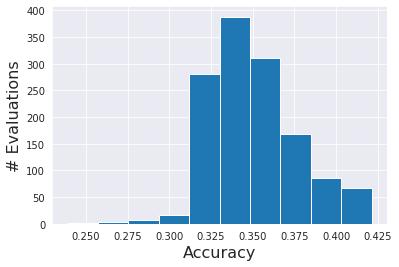

In [22]:
plt.hist(acc_df['acc'])
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('# Evaluations', fontsize=16)
plt.show()

## Best over configs

In [23]:
df

,labs,preds,hue,saturation,value,num,labs_int,sameclass
0,"[409, 530]",409,0.0,0.0,0.0,8,"[409, 530]",True
1,"[409, 530]",409,0.0,0.0,0.1,9,"[409, 530]",True
2,"[409, 530]",409,0.0,0.0,0.2,9,"[409, 530]",True
3,"[409, 530]",409,0.0,0.0,0.3,10,"[409, 530]",True
4,"[409, 530]",409,0.0,0.0,0.4,10,"[409, 530]",True
...,...,...,...,...,...,...,...,...
1853927,[999],999,1.0,1.0,0.6,9,[999],True
1853928,[999],999,1.0,1.0,0.7,9,[999],True
1853929,[999],999,1.0,1.0,0.8,9,[999],True
1853930,[999],999,1.0,1.0,0.9,10,[999],True


In [24]:
perclass_acc_df = df.groupby(all_keys + ['sameclass', 'labs']).agg({'num': 'sum'}).reset_index()
perclass_acc_df = perclass_acc_df.pivot_table(index=all_keys + ['labs'], 
                                              columns='sameclass', values='num',
                                              fill_value=0).reset_index()
perclass_acc_df['acc'] = perclass_acc_df[True] / (perclass_acc_df[True] + perclass_acc_df[False])
perclass_acc_df['count'] = (perclass_acc_df[True] + perclass_acc_df[False])
perclass_acc_df

sameclass,hue,saturation,value,labs,False,True,acc,count
0,0.0,0.0,0.0,"[409, 530]",50,11,0.180328,61
1,0.0,0.0,0.0,[412],53,30,0.361446,83
2,0.0,0.0,0.0,[414],51,18,0.260870,69
3,0.0,0.0,0.0,"[418, 749, 563]",45,7,0.134615,52
4,0.0,0.0,0.0,[419],37,54,0.593407,91
...,...,...,...,...,...,...,...,...
130433,1.0,1.0,1.0,[950],37,7,0.159091,44
130434,1.0,1.0,1.0,[951],35,49,0.583333,84
130435,1.0,1.0,1.0,[954],32,31,0.492063,63
130436,1.0,1.0,1.0,[968],7,1,0.125000,8


In [25]:
avg_df = perclass_acc_df.groupby('labs').agg({'acc': 'mean', 'count': 'sum'}).reset_index()

avg_df

,labs,acc,count
0,"[409, 530]",0.199653,81191
1,[412],0.315507,110473
2,[414],0.368896,91839
3,"[418, 749, 563]",0.203736,69212
4,[419],0.602109,121121
...,...,...,...
93,[950],0.265095,58564
94,[951],0.707900,111804
95,[954],0.604391,83853
96,[968],0.029020,10648


## Per class

In [26]:
perclass_acc_df = perclass_acc_df.loc[perclass_acc_df.groupby('labs')['acc'].idxmax()]

In [27]:
perclass_acc_df

sameclass,hue,saturation,value,labs,False,True,acc,count
106624,0.8,1.0,1.0,"[409, 530]",44,17,0.278689,61
68895,0.5,0.8,1.0,[412],39,44,0.530120,83
13918,0.1,0.1,1.0,[414],26,43,0.623188,69
102315,0.8,0.6,1.0,"[418, 749, 563]",24,28,0.538462,52
74288,0.6,0.2,1.0,[419],27,64,0.703297,91
...,...,...,...,...,...,...,...,...
39783,0.3,0.3,0.9,[950],20,24,0.545455,44
73300,0.6,0.1,1.0,[951],8,76,0.904762,84
33317,0.2,0.8,0.9,[954],9,54,0.857143,63
14796,0.1,0.2,0.7,[968],6,2,0.250000,8


In [28]:
print("Best over configs", 
      100 * sum(perclass_acc_df['acc'] * perclass_acc_df['count']) / sum(perclass_acc_df['count']))

Best over configs 52.84191829484902


In [29]:
if False:
    CM_best = np.zeros((10, 10))

    for l, o in zip(perclass_acc_df['labs'], perclass_acc_df['offset']):
        curr = df[np.logical_and(df['labs'] == l, df['offset'] == o)]
        for p, n in zip(curr['preds'], curr['num']):
            CM_best[l, p] = n
    CM_best = CM_best / np.sum(CM_best, axis=1)
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    sns.heatmap(np.around(CM_best, decimals=2), cmap='RdBu_r', ax=ax, annot=True)
    ax.set_xticklabels([CLASS_DICT['CIFAR'][i] for i in range(10)], rotation=30)
    ax.set_yticklabels([CLASS_DICT['CIFAR'][i] for i in range(10)], rotation=0)

    plt.show()

In [30]:
perclass_acc_df.to_csv('per_class_color_good.csv')